In [26]:
"""!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install torch
!pip install scikit-learn
!pip install torchvision
!pip install tqdm"""

'!pip install matplotlib\n!pip install numpy\n!pip install pandas\n!pip install seaborn\n!pip install torch\n!pip install scikit-learn\n!pip install torchvision\n!pip install tqdm'

In [27]:
import torch
import torch_directml
dml = torch_directml.device()
print(dml)
tensor1 = torch.tensor([1]).to(dml) # Note that dml is a variable, not a string!
tensor2 = torch.tensor([2]).to(dml)
dml_algebra = tensor1 + tensor2
print(dml_algebra.item())


privateuseone:0
3


In [28]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from sklearn.model_selection import GridSearchCV
from torch.utils.data import Dataset, Subset
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.base import BaseEstimator, ClassifierMixin

Hyperparameters

In [29]:
class Hparams:
    def __init__(self, train_batch_size=64, test_batch_size=64, learning_rate=0.001, num_epochs = 10, val_split=0.3, test_split=0.2, model_path='saved_model', dataset_path='Data'):
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.val_split = val_split
        self.test_split = test_split
        self.model_path = model_path
        self.dataset_path = dataset_path

Dataset Loader

In [30]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset = None, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
            mean = torch.mean(x)
            std = torch.std(x)
        return x, mean, std, y

    def __len__(self):
        return len(self.subset)

In [31]:
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.ToTensor(),
    ])
    return transform

In [32]:
def get_transforms_train():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.RandomAffine(0, translate=None, scale= (0.95, 1.05), shear=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()
    ])
    return transform

In [33]:
def get_sample_weights(dataset, train_dataset):

    # Code taken from:
    #     https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/
    y_train_indices = train_dataset.indices
    print(train_dataset.indices)
    print(dataset.targets)
    y_train = [dataset.targets[i] for i in y_train_indices]

    class_sample_counts = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weights = 1. / class_sample_counts
    sample_weights = np.array([weights[t] for t in y_train])
    sample_weights = torch.from_numpy(sample_weights)

    return sample_weights

In [34]:
def get_data_loaders(hparams):
    # Loading the dataset
    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    # Splitting dataset into train, validation and test partitions.
    proportions = [(1 - hparams.val_split - hparams.test_split), hparams.val_split, hparams.test_split]
    lengths = [int(p * len(dataset)) for p in proportions]
    lengths[-1] = len(dataset) - sum(lengths[:-1])

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)

    print(type(train_dataset))

    print(type(train_dataset[0][0]))

    print(f'train size: {lengths[0]}, val size: {lengths[1]}, test size: {lengths[2]}')

    data_transforms = {
        'train': get_transforms_train(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

    plt.imshow(train_dataset[0][0].moveaxis(0,2), cmap='gray') 

    # Creating loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)

    return train_loader, val_loader, test_loader

In [35]:
from sklearn.model_selection import train_test_split

def get_split_dataset_loaders(hparams):

    folder_path = 'Data\Mild Dementia'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Proportions you want to split into (e.g., 60% train, 20% validation, 20% test)
    train_proportion = 1 - hparams.val_split - hparams.test_split
    validation_proportion = hparams.val_split
    test_proportion = hparams.test_split

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    index = 0
    location_change = [0]
    for i in range(len(dataset)):
        if (dataset[i][1] != index):
            location_change.append(i)
            index += 1

    train_index = []
    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                train_index.append(ii+location_change[0])
            
    val_index = []
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                val_index.append(ii+location_change[0])

    test_index = []
    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[0])


    folder_path = 'Data\Regular'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                train_index.append(ii+location_change[1])
            
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                val_index.append(ii+location_change[1])

    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[1])





    folder_path = 'Data\Very mild Dementia'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                train_index.append(ii+location_change[2])     

    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                val_index.append(ii+location_change[2])

    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[2])

    train_dataset = Subset(dataset, train_index)
    val_dataset = Subset(dataset, val_index)
    test_dataset =  Subset(dataset, test_index)

    data_transforms = {
        'train': get_transforms_train(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)

    print(check_array_overlap(train_index, val_index, test_index))

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [36]:
def check_array_overlap(arr1, arr2, arr3):
    set1 = set(arr1)
    set2 = set(arr2)
    set3 = set(arr3)

    if set1.intersection(set2) or set1.intersection(set3) or set2.intersection(set3):
        return True
    else:
        return False

Model

In [37]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, kernel= (5,5)):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, mid_channel, kernel_size= kernel, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(mid_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channel, out_channel, kernel_size= kernel, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)

        x = self.pool(x)

        return x

In [38]:
class LinearBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [39]:
class LinearBlockDropout(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.convblock1 = ConvBlock(1, 2, 4)

        self.flatten = nn.Flatten(start_dim=1)

        self.linearblock1 = LinearBlockDropout(59536, 1000)
        self.linearblock4 = LinearBlock(1000 + 2, 3)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, img, mean, std):
        x = self.convblock1(img)

        x = self.flatten(x)

        x = self.linearblock1(x)

        x = torch.concat([x, mean.unsqueeze(1), std.unsqueeze(1)], dim=-1)
        
        x = self.linearblock4(x)

        x = self.softmax(x)

        return x

Train and Validate Loops

In [41]:
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    batch_size = 0

    targets, preds = [], []

    for batch_idx, (img, mean, std, target) in train_loader:
        img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
        batch_size = len(img)

        optimizer.zero_grad()
        output = model(img, mean, std)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)

        targets.append(target.cpu().numpy())
        preds.append(pred.cpu().numpy().flatten())

        train_correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

        train_loader.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        train_loader.set_postfix(loss=train_loss / ((batch_idx+1) * len(img)), accuracy=100. * train_correct / ((batch_idx+1) * len(img)))

    targets = np.concatenate(targets)
    preds = np.concatenate(preds)
    f1 = f1_score(targets, preds, average='macro')

    train_length = train_loader.total * batch_size
    train_loss /= train_length
    train_accuracy = 100. * train_correct / train_length
    return train_loss, train_accuracy, f1

In [42]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_correct = 0
    total_size = 0
    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(val_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            batch_size = len(img)
            output = model(img, mean, std)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(target.view_as(pred)).sum().item()

            total_size += len(img)
    val_loss /= total_size
    val_accuracy = 100. * val_correct / total_size
    return val_loss, val_accuracy

In [43]:
def predict(model, data_loader, criterion, device, eval=False):
    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(data_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            output = model(img, mean, std)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)

            total_size += len(img)

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size

    if eval:
        return pred_loss, pred_accuracy, predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()

In [44]:
def train_and_validate(model, train_loader, val_loader, test_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), ascii=' >=')
        train_loss, train_accuracy, f1 = train(model, loop, criterion, optimizer, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

#        predictions, labels = predict(model, val_loader, criterion, device, eval=False)

#        conf_mat = confusion_matrix(labels, predictions)
#        class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
#        df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)
#        heat_map = sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')
#        plt.show()
#
#        for i in range(len(predictions)):
#            if (predictions[i] != labels[i]):
#                print(f'Image: {val_loader.dataset.subset.dataset.imgs[i][0]}, Predicted: {class_to_idx[int(predictions[i])]}, Actual: {class_to_idx[int(labels[i])]}')
        
        if early_stopping is not None:
            early_stopping(val_accuracy)

            if early_stopping.early_stop:
                tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')
                print(f'Early stopping at Epoch {epoch+1}')
                break

        tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

Early Stopping

In [45]:
class EarlyStopping:
    def __init__(self, patience=5, mode='max'):
        self.counter = 0
        self.patience = patience
        self.early_stop = False
        self.mode = mode

        if self.mode == 'max':
            self.ref_value = float('-inf')
        elif self.mode == 'min':
            self.ref_value = float('inf')
        else:
            raise Exception(f'Undefined mode for EarlyStopping - mode: {mode}\n'
                             'Available modes are ["max", "min"]')

    def __call__(self, value):
        if self.mode == 'max':
            if value <= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value
        elif self.mode == 'min':
            if value >= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value

        if self.counter == self.patience:
            self.early_stop = True

Visualize

In [46]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [47]:
def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Training and Evaluation

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch_directml.device()
print(f"Using {device} device.")

Using privateuseone:0 device.


In [49]:
hparams = Hparams()

In [50]:
train_loader, val_loader, test_loader, train_dataset , val_dataset , test_dataset = get_split_dataset_loaders(hparams)

KeyboardInterrupt: 

In [ ]:
early_stopping = EarlyStopping(patience=3, mode='max')

Training

In [ ]:
model = CNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hparams.learning_rate)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model,
                                                                                train_loader,
                                                                                val_loader,
                                                                                test_loader,
                                                                                criterion,
                                                                                optimizer,
                                                                                device,
                                                                                num_epochs=hparams.num_epochs,
                                                                                #early_stopping=early_stopping,
                                                                                )

Epoch [1/10]: 100%|==========| 660/660 [06:16<00:00,  1.75it/s, accuracy=76.4, loss=0.0129]


	 => train_f1=0.7622, val_loss=0.0121, val_acc=80.9509


Epoch [2/10]: 100%|==========| 660/660 [06:07<00:00,  1.80it/s, accuracy=90.7, loss=0.0106]


	 => train_f1=0.9072, val_loss=0.0100, val_acc=93.9468


Epoch [3/10]: 100%|==========| 660/660 [10:22<00:00,  1.06it/s, accuracy=90.2, loss=0.0105] 


	 => train_f1=0.9014, val_loss=0.0098, val_acc=93.6004


Epoch [4/10]: 100%|==========| 660/660 [06:27<00:00,  1.70it/s, accuracy=95.9, loss=0.00954]


	 => train_f1=0.9584, val_loss=0.0092, val_acc=97.5401


Epoch [5/10]: 100%|==========| 660/660 [06:49<00:00,  1.61it/s, accuracy=95.7, loss=0.00951]


	 => train_f1=0.9566, val_loss=0.0094, val_acc=96.0406


Epoch [6/10]: 100%|==========| 660/660 [06:46<00:00,  1.62it/s, accuracy=97.2, loss=0.00922]


	 => train_f1=0.9719, val_loss=0.0089, val_acc=99.1420


Epoch [7/10]: 100%|==========| 660/660 [06:47<00:00,  1.62it/s, accuracy=97.5, loss=0.00913]


	 => train_f1=0.9753, val_loss=0.0090, val_acc=97.9888


Epoch [8/10]: 100%|==========| 660/660 [06:45<00:00,  1.63it/s, accuracy=97.1, loss=0.00918]


	 => train_f1=0.9708, val_loss=0.0090, val_acc=97.8550


Epoch [9/10]: 100%|==========| 660/660 [06:54<00:00,  1.59it/s, accuracy=98.1, loss=0.009]  


	 => train_f1=0.9809, val_loss=0.0090, val_acc=97.9377


Epoch [10/10]: 100%|==========| 660/660 [06:46<00:00,  1.62it/s, accuracy=98.1, loss=0.00899]


	 => train_f1=0.9806, val_loss=0.0089, val_acc=98.2879


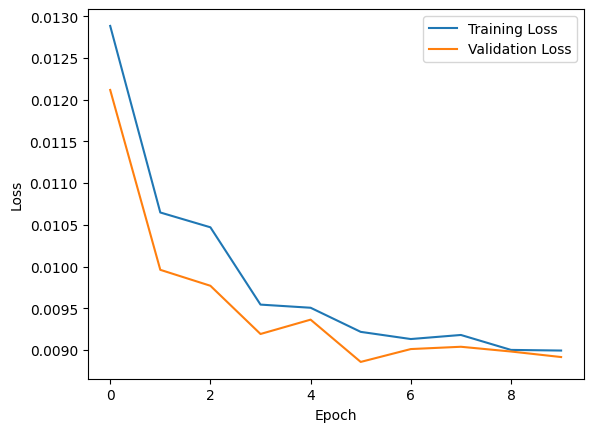

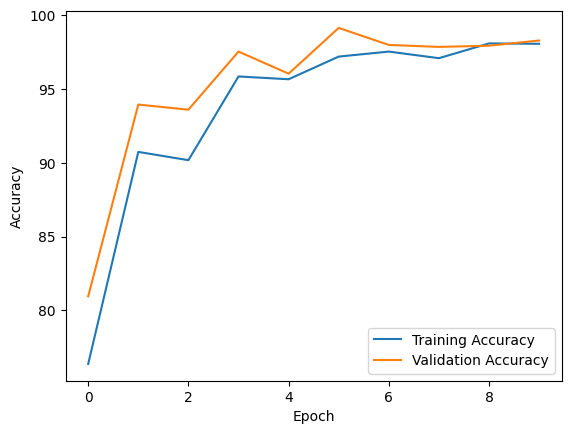

In [ ]:
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

Testing

In [ ]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0090, Test Accuracy: 97.90%


Saving Model

In [ ]:
def save_model(model, hparams):
    os.makedirs(hparams.model_path, exist_ok=True)

    model_name = model.__class__.__name__ + '_' + datetime.now().strftime("%Y_%m_%d-%H_%M_%S" + '.pt')

    try:
        torch.save(model.state_dict(), os.path.join(hparams.model_path, model_name))
        return True
    except:
        return False

In [ ]:
save_model(model, hparams)

True

Loading the Model

In [ ]:
#path_to_pt_file = "saved_model\CNN_2023_07_18-01_19_25.pt"

#saved_model = torch.load(path_to_pt_file)

#model.load_state_dict(saved_model)

Confusion Matrix

In [ ]:
predictions, labels = predict(model, test_loader, criterion, device, eval=False)

In [ ]:
conf_mat = confusion_matrix(labels, predictions)
class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)

print(df_cm)

                    Mild Dementia  Regular  Very mild Dementia
Mild Dementia                1209        0                  11
Regular                        59    13331                 213
Very mild Dementia             31       55                2659


<Axes: >

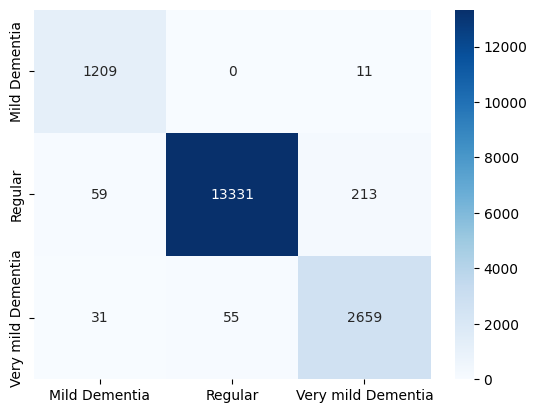

In [ ]:
sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')

Classification Report

In [ ]:
print(classification_report(labels, predictions, target_names=class_to_idx))

print(labels)
print(predictions)

                    precision    recall  f1-score   support

     Mild Dementia       0.93      0.99      0.96      1220
           Regular       1.00      0.98      0.99     13603
Very mild Dementia       0.92      0.97      0.94      2745

          accuracy                           0.98     17568
         macro avg       0.95      0.98      0.96     17568
      weighted avg       0.98      0.98      0.98     17568

[0 0 0 ... 2 2 2]
[[0]
 [0]
 [0]
 ...
 [2]
 [2]
 [2]]


In [ ]:
def calculate_precision():
    precisions = []
    for row in range(4):
        precisions.append(df_cm[row][row] / (df_cm[0][row] + df_cm[1][row] + df_cm[2][row] + df_cm[3][row]))
    
    total_sum = 0
    overall_precision = 0
    for row in range(4):
        row_sum = 0
        for col in range(4):
            row_sum += df_cm[row][col]
        total_sum += row_sum
        overall_precision += precisions[row] * row_sum
    precisions.append(overall_precision / total_sum)
    return precisions

In [ ]:
def calculate_recall():
    recalls = []
    for col in range(4):
        recalls.append(df_cm[col][col] / (df_cm[col][0] + df_cm[col][1] + df_cm[col][2] + df_cm[col][3]))
    
    total_sum = 0
    overall_recall = 0
    for col in range(4):
        col_sum = 0
        for row in range(4):
            col_sum += df_cm[row][col]
        total_sum += col_sum
        overall_recall += recalls[col] * col_sum
    recalls.append(overall_recall / total_sum)
    return recalls

In [ ]:
def calculate_f1(precisions, recalls):
    f1_scores = []
    for i in range(5):
        f1_scores[i] = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
    return f1_scores

In [ ]:
import pandas as pd
from tabulate import tabulate

# Data for the table
variables = ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4', 'Variable 5']
percentages = ['20%', '35%', '15%', '10%', '20%']
data = {'Variables': variables, 'Percentages': percentages}

# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

# Convert the DataFrame to a LaTeX table
table = tabulate(df, headers='keys', tablefmt='latex', showindex=False)

# Print the LaTeX table
print(table)

\begin{tabular}{ll}
\hline
 Variables   & Percentages   \\
\hline
 Variable 1  & 20\%           \\
 Variable 2  & 35\%           \\
 Variable 3  & 15\%           \\
 Variable 4  & 10\%           \\
 Variable 5  & 20\%           \\
\hline
\end{tabular}


In [ ]:
def predict_testing_data(model, criterion, device, eval=False):

    ood_dataset = ImageFolder(root='DataOOD', transform= transforms.Compose([transforms.Grayscale()]))
    ood_dataset = CustomDataset(ood_dataset, transform= get_transforms())
    ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=hparams.test_batch_size)

    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    with torch.no_grad():
        for batch_idx, (img, mean, std, target) in enumerate(ood_loader):
            img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            output = model(img, mean, std)
            #print(output)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            print(pred)
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)

            total_size += len(img)

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size

    if eval:
        return pred_loss, pred_accuracy, predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()
    
predict_testing_data(model, criterion, device, eval=False)

tensor([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], device='privateuseone:0')


(array([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))